# Stroke Prognosis: clustering

<p>
Curso de Minería de Datos <br>
Autor: Cristian Pavez Hormazábal
</p>


In [11]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.decomposition import PCA


In [12]:
models = {
    "Decision Tree": sk.tree.DecisionTreeClassifier(),
    "Gaussian Naive Bayes": sk.naive_bayes.GaussianNB(),   # En el test no salió bueno
    "Bernoulli Naive Bayes": sk.naive_bayes.BernoulliNB(), # En el test no salió bueno
    "SVM": sk.svm.SVC(probability=True),                   # En el test no salió bueno
    "Random Forest": sk.ensemble.RandomForestClassifier(),
    "KNN": sk.neighbors.KNeighborsClassifier(n_neighbors=5),
}

def entrenar(x, y):
    all_results = []
    for name, model in models.items():
        results = []
        x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, test_size=0.2, random_state=42)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        # Obtener probabilidades o scores para ROC
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(x_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(x_test)
        else:
            y_score = None
        cm = sk.metrics.confusion_matrix(y_test, y_pred)
        acc = sk.metrics.accuracy_score(y_test, y_pred)
        prec = sk.metrics.precision_score(y_test, y_pred)
        rec = sk.metrics.recall_score(y_test, y_pred)
        f1 = sk.metrics.f1_score(y_test, y_pred)
        results.append({
            "confusion_matrix": cm,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "y_test": y_test,
            "y_score": y_score
        })
        all_results.append({f"{name}": results})
        if name == "Decision Tree":
            plt.figure(figsize=(20, 10))
            sk.tree.plot_tree(model, feature_names=x.columns, class_names=['No Stroke', 'Stroke'], filled=True, rounded=True, fontsize=10)
            plt.title("Estructura del Árbol de Decisión")
            plt.show()
    return all_results

def graficar_resultados(all_results):
    for model in all_results:
        name, results = list(model.items())[0]
        cms = [r['confusion_matrix'] for r in results]
        tps = [cm[0][0] for cm in cms]
        fns = [cm[0][1] for cm in cms]
        fps = [cm[1][0] for cm in cms]
        tns = [cm[1][1] for cm in cms]
        accs = [r['accuracy'] for r in results]
        precs = [r['precision'] for r in results]
        recs = [r['recall'] for r in results]
        f1s = [r['f1_score'] for r in results]

        # Crear boxplot de las métricas
        data = [accs, precs, recs, f1s]
        labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        plt.figure(figsize=(8, 6))
        plt.boxplot(data, tick_labels=labels)
        plt.title(f'Boxplot de métricas para {name}')
        plt.ylabel('Score')
        plt.ylim(0, 1) 
        plt.grid(True)
        plt.show()

        # Matriz de confusión promedio
        avg_cm = np.array([
            [np.mean(tps), np.mean(fns)],
            [np.mean(fps), np.mean(tns)]
        ])
        plt.figure(figsize=(4, 4))
        sns.heatmap(avg_cm, annot=True, fmt=".1f", cmap="Blues", xticklabels=["Pred. Stroke", "Pred. no Stroke"], yticklabels=["Real Stroke", "Real no Stroke"])
        plt.title(f'Matriz de confusión promedio para {name}')
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.show()

        # Curva ROC
        from sklearn.metrics import roc_curve, auc
        # Curva ROC promedio
        fpr_list = []
        tpr_list = []
        auc_list = []
        for r in results:
            # Verifica si el modelo tiene predict_proba o decision_function
            try:
                y_score = r.get('y_score', None)
                if y_score is not None:
                    fpr, tpr, _ = roc_curve(r['y_test'], y_score)
                    fpr_list.append(fpr)
                    tpr_list.append(tpr)
                    auc_list.append(auc(fpr, tpr))
            except Exception as e:
                continue

        if fpr_list and tpr_list:
            plt.figure(figsize=(6, 6))
            for i, (fpr, tpr) in enumerate(zip(fpr_list, tpr_list)):
                plt.plot(fpr, tpr, alpha=0.3, label=f'ROC split {i+1}')
            mean_auc = np.mean(auc_list)
            plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Curvas ROC solapadas para {name}\n(AUC promedio = {mean_auc:.2f})')
            plt.legend(loc='lower right', fontsize='small', ncol=2)
            plt.grid(True)
            plt.show()    

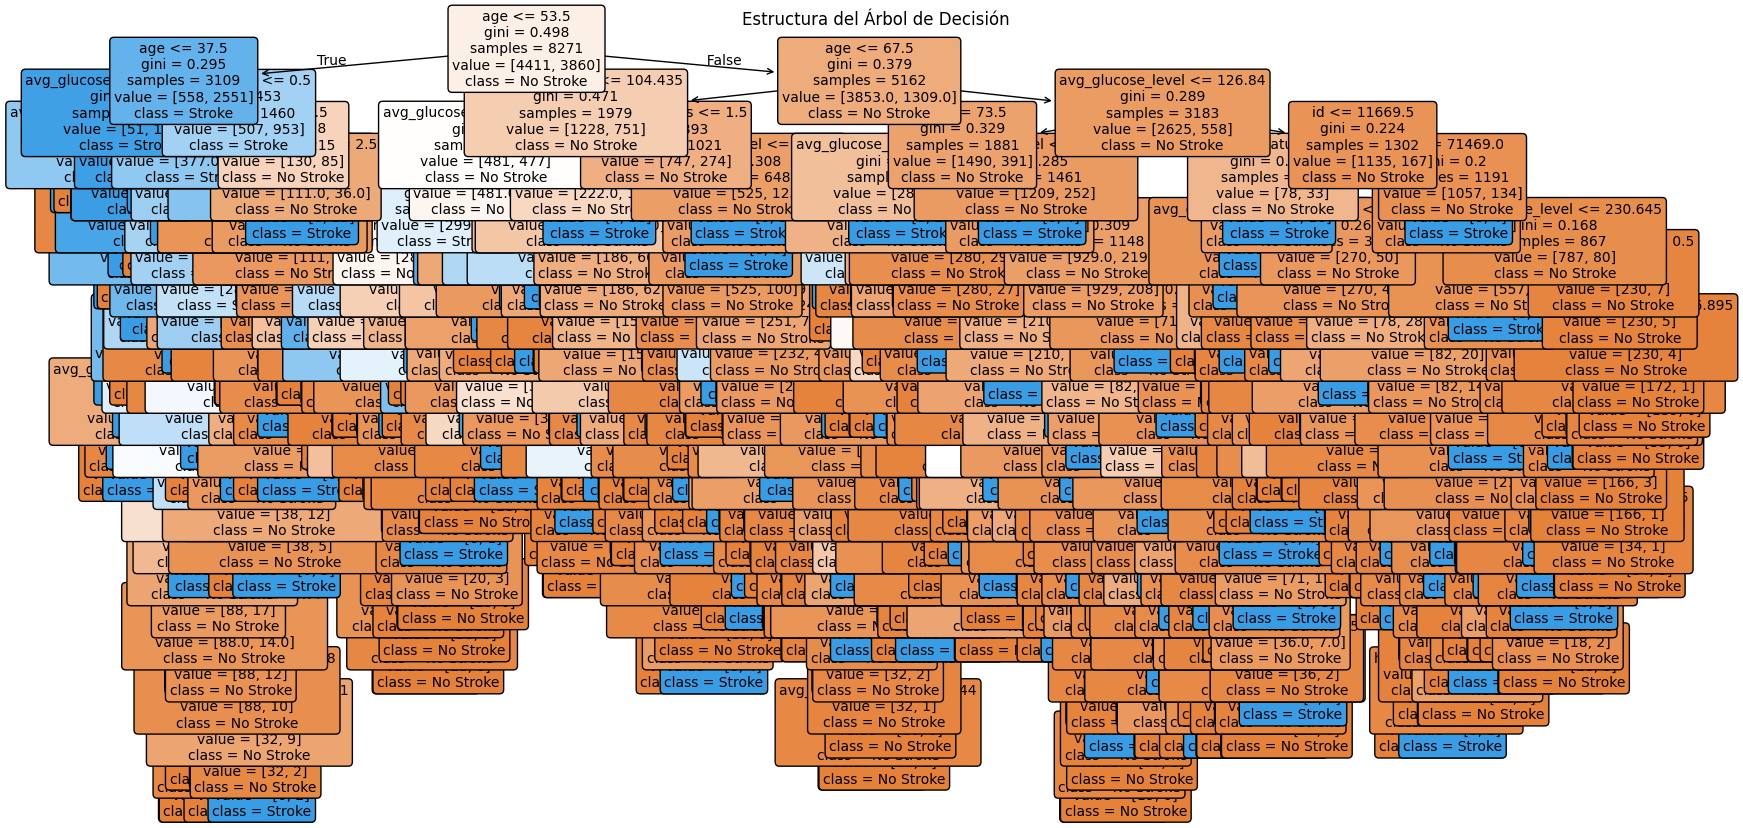

C:\Users\Kiki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


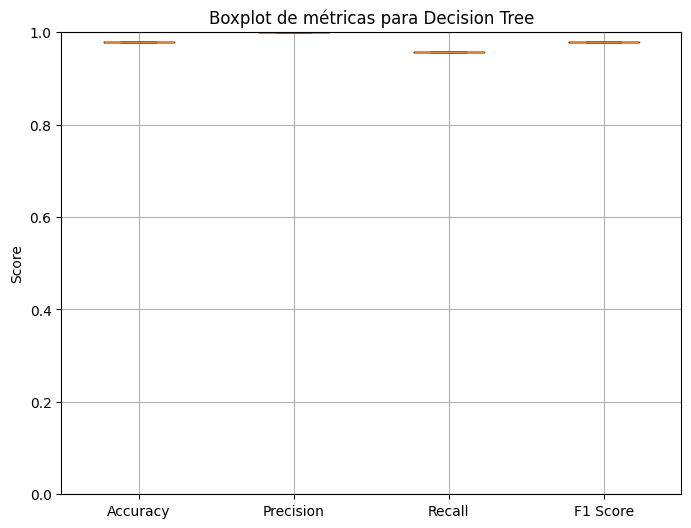

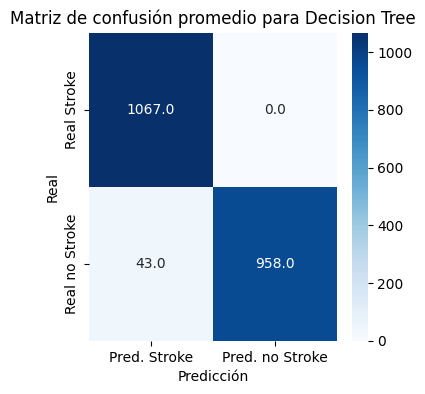

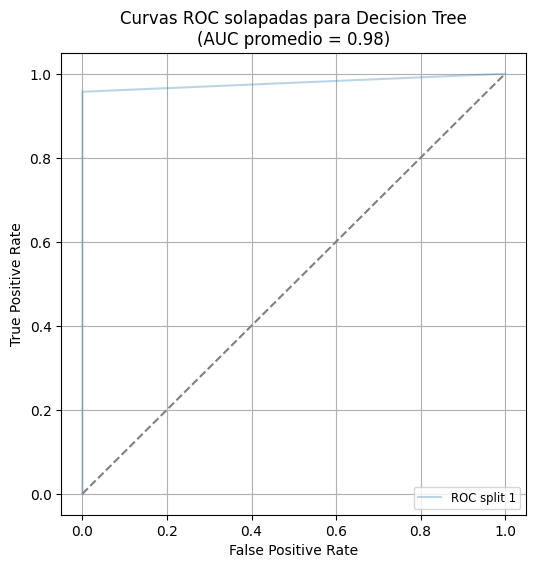

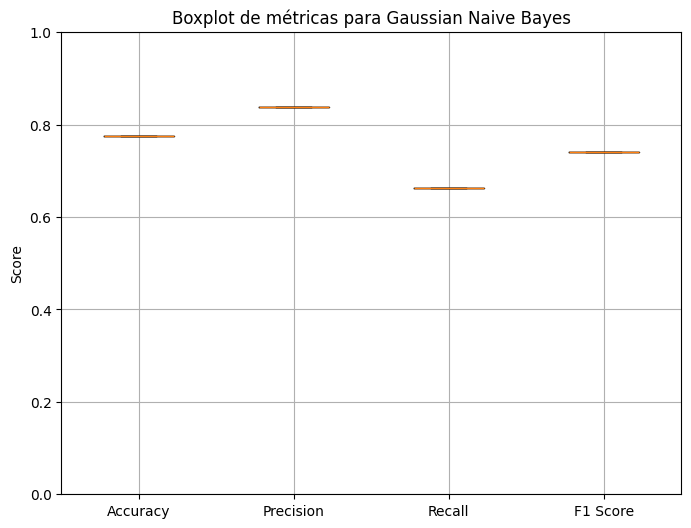

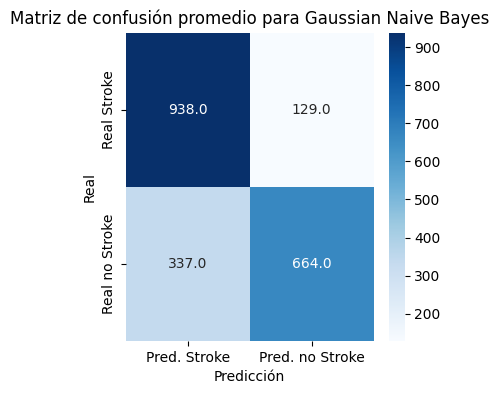

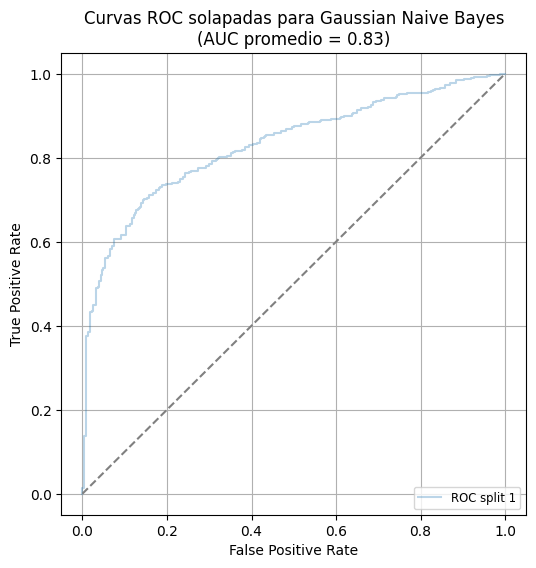

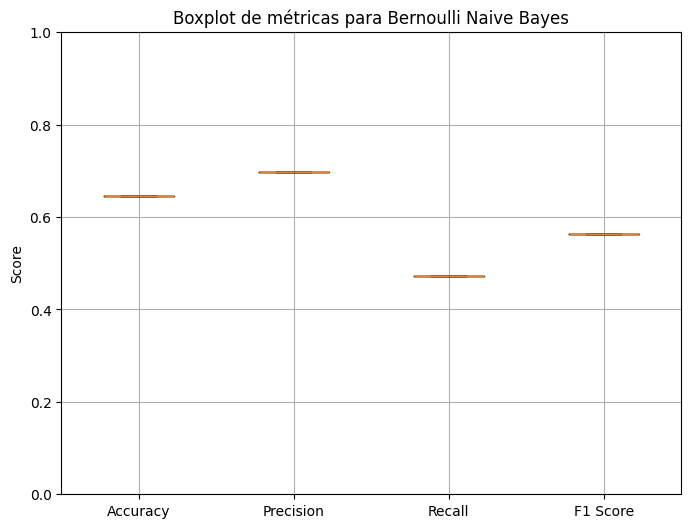

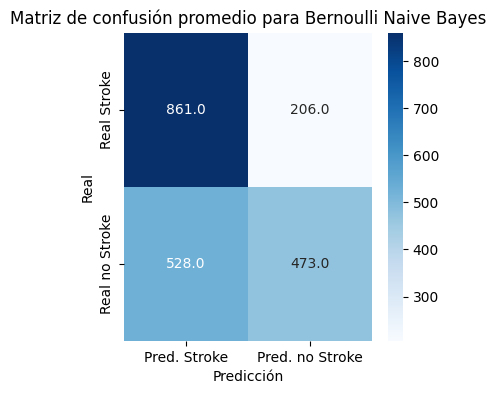

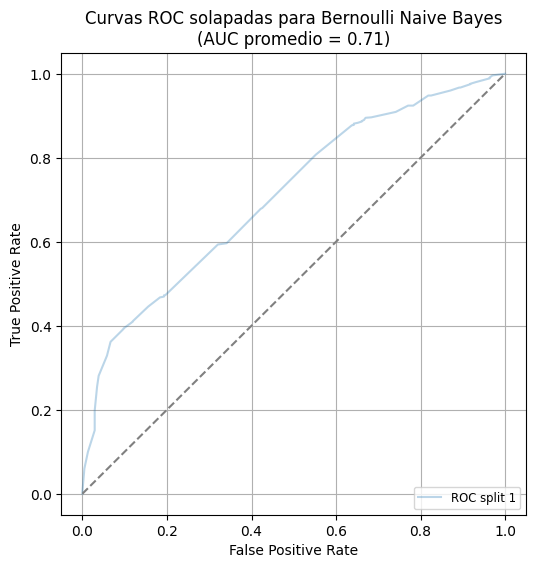

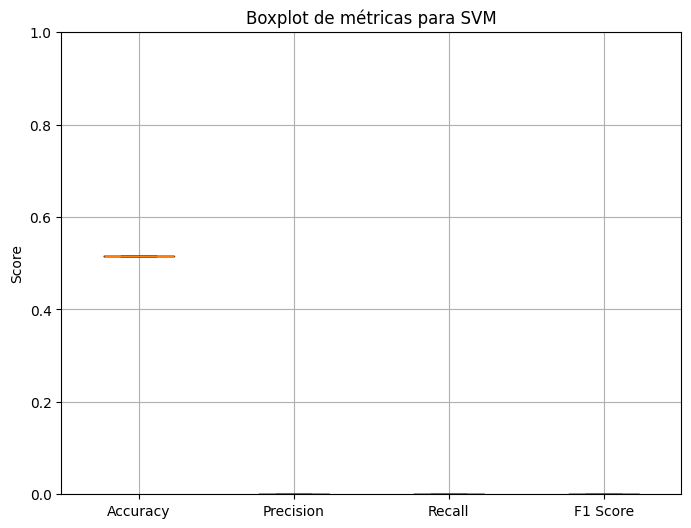

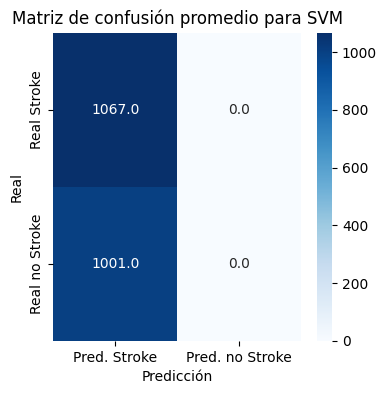

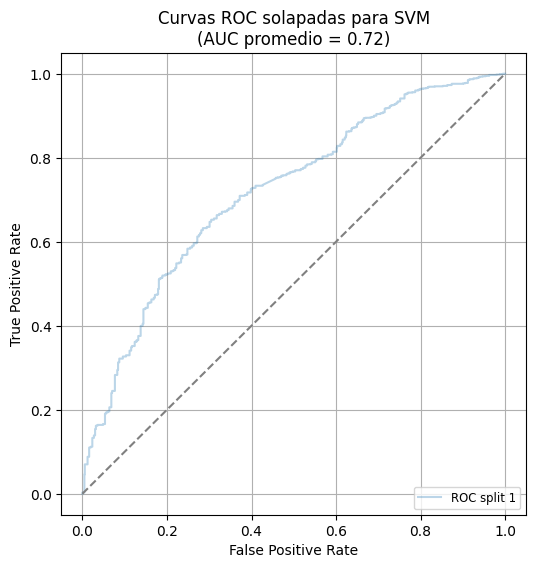

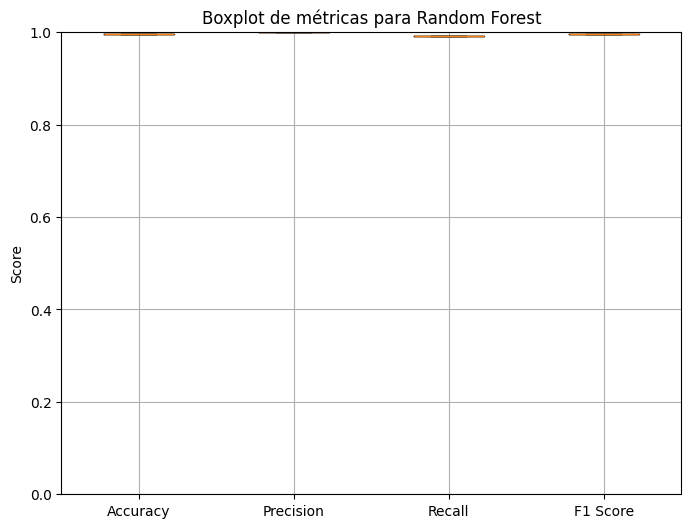

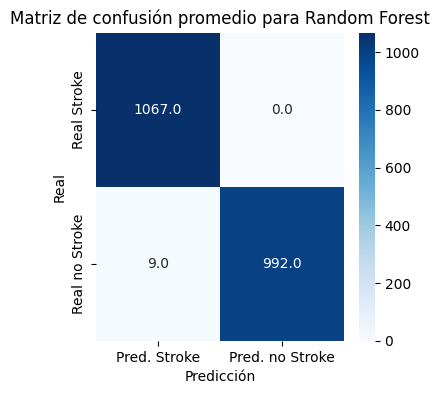

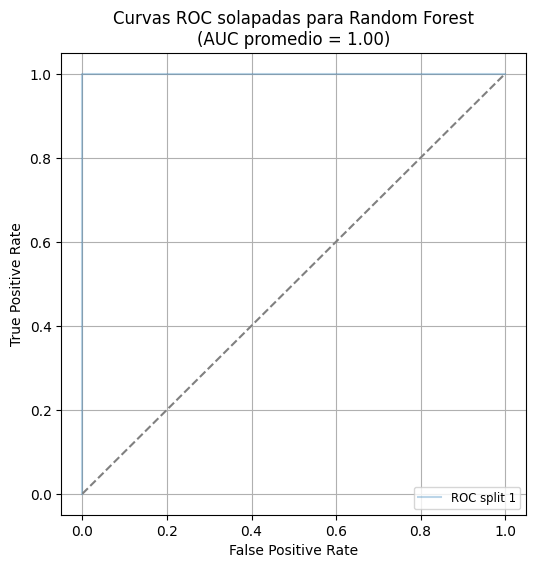

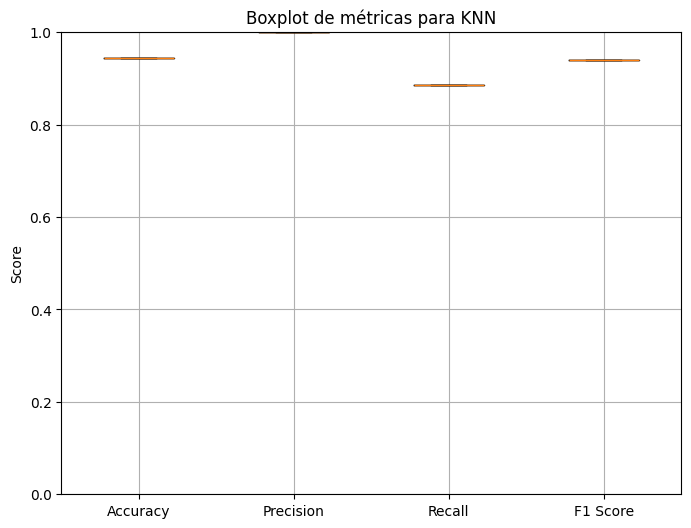

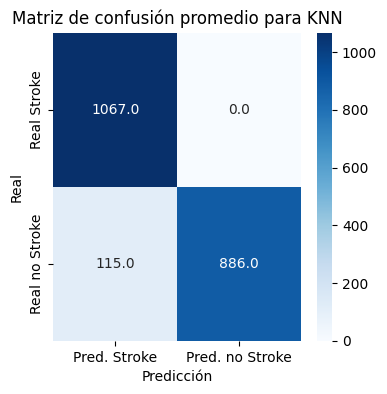

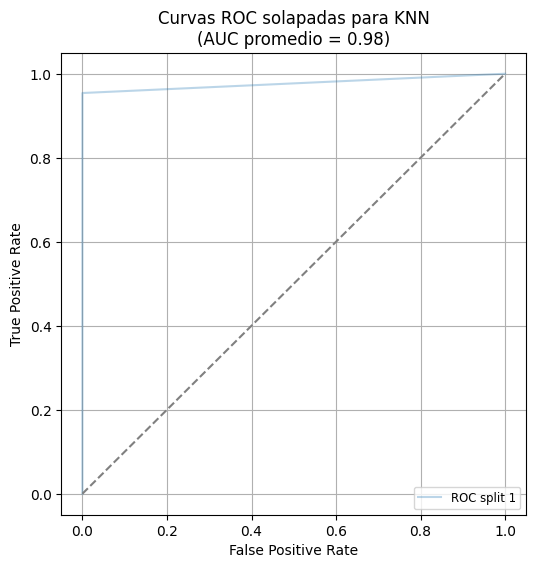

In [13]:
# Importación de datos
dataset = pd.read_csv("all-data.csv")
dataset['gender'] = dataset['gender'].map({'Male': 1, 'Female': 0, 'Other': 2})
dataset['ever_married'] = dataset['ever_married'].map({'Yes': 1, 'No': 0})
dataset['work_type'] = dataset['work_type'].map({'Private': 4, 'Self-employed': 2, 'Govt_job': 3, 'children': 1, 'Never_worked': 0})
dataset['Residence_type'] = dataset['Residence_type'].map({'Rural': 0, 'Urban': 1})
dataset['smoking_status'] = dataset['smoking_status'].map({'Unknown': 0, 'never smoked': 1, 'formerly smoked': 2, 'smokes': 3})
dataset['stroke'] = dataset['stroke'].map({1: 0, 0: 1})

# Dividir el dataset en personas con y sin stroke
no_stroke_data = dataset[dataset['stroke'] == 1]
stroke_data = dataset[dataset['stroke'] == 0]

# Sobre-representar los datos de stroke (multiplicar por 5)
dataset = pd.concat([stroke_data] * 22, ignore_index=True)

# Combinar los datasets
dataset = pd.concat([dataset, no_stroke_data], ignore_index=True)

# Mezclar los datos para evitar orden
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

dataset = dataset.drop('bmi', axis=1)
dataset = dataset.dropna()


x = dataset.drop('stroke', axis=1)
y = dataset['stroke']

results = entrenar(x, y)

graficar_resultados(results)

## Clustering con KMeans y comparación con la variable real 'stroke'

Silhouette Score para k=5000: 0.544
Adjusted Rand Index (ARI): 0.002


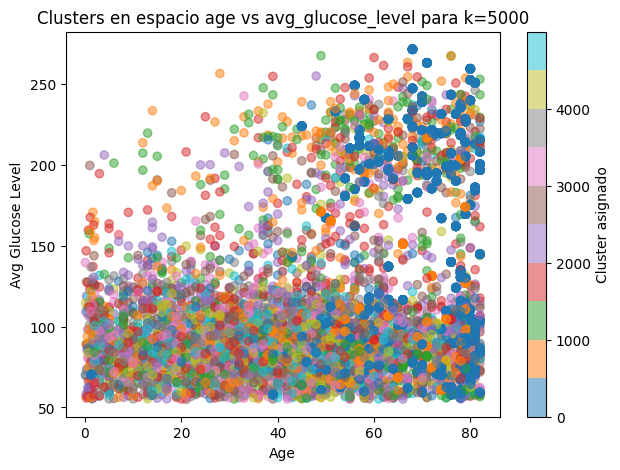

C:\Users\Kiki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


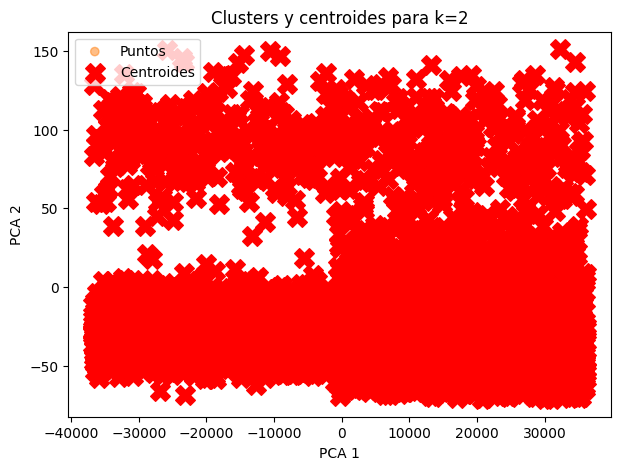

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002B75E97BCE0> (for post_execute), with arguments args (),kwargs {}:


MemoryError: Unable to allocate 763. MiB for an array with shape (5000, 5000, 4) and data type float64

MemoryError: Unable to allocate 191. MiB for an array with shape (5000, 5000) and data type float64

<Figure size 640x480 with 2 Axes>

In [15]:
# Seleccionar solo variables numéricas para clustering (excluyendo 'stroke')
X = dataset.drop('stroke', axis=1)
y_true = dataset['stroke']

from sklearn.metrics import silhouette_score

for i in range(1):
    # Ajustar KMeans con 2+ clusters
    kmeans = KMeans(n_clusters=5000, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X)
    
    # Calcular Silhouette Score
    sil_score = silhouette_score(X, clusters)
    print(f'Silhouette Score para k={5000}: {sil_score:.3f}')
    
    # Comparar los clusters con la variable real
    ari = adjusted_rand_score(y_true, clusters)
    print(f'Adjusted Rand Index (ARI): {ari:.3f}')

    # Visualización 2D usando solo age y avg_glucose_level
    plt.figure(figsize=(7,5))
    plt.scatter(dataset['age'], dataset['avg_glucose_level'], c=clusters, cmap='tab10', alpha=0.5, label='Puntos')
    plt.xlabel('Age')
    plt.ylabel('Avg Glucose Level')
    plt.title(f'Clusters en espacio age vs avg_glucose_level para k={5000}')
    plt.colorbar(label='Cluster asignado')
    plt.show()

    # Reducción a 2D para graficar (PCA)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    centroids_pca = pca.transform(kmeans.cluster_centers_)
    plt.figure(figsize=(7,5))
    scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10', alpha=0.5, label='Puntos')
    plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='red', marker='X', s=200, label='Centroides')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title(f'Clusters y centroides para k={i+2}')
    plt.legend()
    plt.show()

    # Matriz de confusión
    cm = confusion_matrix(y_true, clusters)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Cluster {j}' for j in range(i+2)], yticklabels=['Stroke', 'No Stroke'])
    plt.xlabel('Cluster asignado')
    plt.ylabel('Clase real')
    plt.title('Matriz de confusión: Clusters vs Stroke real')
    plt.show()

**Nota:** El clustering no necesariamente asigna los mismos números de cluster a las clases reales, pero la matriz de confusión y el ARI permiten evaluar la correspondencia.